In [61]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit, prange
from typing import List, Tuple
import glob
import os
import math

In [62]:
# ---------------- Gamma Correction ----------------
def inv_gamma(u: np.ndarray) -> np.ndarray:
    """Convert sRGB values [0,1] to linear RGB."""
    mask = (u <= 0.04045)
    return np.where(mask, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)

def gamma_corr(u: np.ndarray) -> np.ndarray:
    """Convert linear RGB [0,1] back to sRGB."""
    mask = (u <= 0.0031308)
    return np.where(mask, 12.92 * u, 1.055 * (u ** (1 / 2.4)) - 0.055)

### Poisson disk sampling

In [64]:
# ---------------- Poisson Disk Sampling ----------------
def poisson_disk_sampling(image: np.ndarray,
                          num_samples=27,
                          initial_rs=0.1,
                          min_rs=0.01,
                          max_attempts=5000) -> np.ndarray:
    t0 = time.time()
    pixels = image.reshape(-1, 3).copy()
    np.random.shuffle(pixels)
    rs = initial_rs
    attempts = 0
    samples = []
    while len(samples) < num_samples and rs >= min_rs:
        for color in pixels:
            if not samples or np.min(np.linalg.norm(np.array(samples)-color, axis=1)) >= 2*rs:
                samples.append(color)
                if len(samples) >= num_samples:
                    break
            attempts += 1
            if attempts > max_attempts:
                rs *= 0.5
                attempts = 0
                break
    samples = np.array(samples, dtype=np.float32)
    print(f"[Sampler] Poisson disk sampling: {time.time()-t0:.3f}s → {len(samples)} samples")
    return samples

In [65]:
def uniform_sampling(image: np.ndarray, num_samples: int = 27) -> np.ndarray:
    t0 = time.time()
    pixels = image.reshape(-1, 3).copy()
    total = pixels.shape[0]

    if total <= num_samples:
        samples = pixels
    else:
        step = total // num_samples
        indices = np.arange(0, step * num_samples, step)
        samples = pixels[indices]

    print(f"[Sampler] Uniform sampling: {time.time() - t0:.3f}s → {len(samples)} samples")
    return samples.astype(np.float32)

### Spatial Filtering O(1)

#### Box Filter O(1)

In [66]:
# ---------------- Box‐filter O(1) ---------------------------
# cv2 (C++)
def box_filter(img: np.ndarray,
               samples: np.ndarray,
               sigma_r: float = 0.1,
               spatial_radius: int = 15,
               eps: float = 1e-6):
    Jks, Wks = [], []
    ksize = (2*spatial_radius + 1, ) * 2   # (ksize, ksize)

    for k in samples.astype(np.float32):
        diff = img - k[None, None, :]
        d2   = np.sum(diff * diff, axis=2, dtype=np.float32)
        w    = np.exp(-d2 / (2 * sigma_r * sigma_r), dtype=np.float32)  # (H,W)

        num = cv2.boxFilter((img * w[..., None]).astype(np.float32),
                            ddepth=-1, ksize=ksize,
                            normalize=False,
                            borderType=cv2.BORDER_REFLECT)

        Wk  = cv2.boxFilter(w, ddepth=-1, ksize=ksize,
                            normalize=False,
                            borderType=cv2.BORDER_REFLECT) + eps

        Jks.append(num)
        Wks.append(Wk.squeeze())

    return Jks, Wks


#### Gaussian-filter O(1) IIR implement

In [67]:
import math
import numpy as np
from numba import njit, prange

# ---------- 1) Deriche coefficients ----------
@njit(cache=True, fastmath=True)
def deriche_coeffs(sigma: float):
    if sigma <= 0:
        raise ValueError("sigma must be > 0")
    alpha = 1.793 / sigma
    ema   = math.exp(-alpha)
    ema2  = math.exp(-2 * alpha)
    k     = (1 - ema) ** 2 / (1 + 2 * alpha * ema - ema2)

    a0 = k
    a1 = k * (alpha - 1) * ema
    a2 = k * (alpha + 1) * ema
    a3 = -k * ema2
    b1 = 2 * ema
    b2 = - ema2
    return a0, a1, a2, a3, b1, b2

# ---------- 2) 1D Deriche filter with mirror-init ----------
@njit(fastmath=True, cache=True)
def deriche_line(src, dst, a0, a1, a2, a3, b1, b2):
    N, C = src.shape
    for c in range(C):
        # forward pass: init from leftmost pixel (mirror)
        xm1 = src[0, c]
        ym1 = src[0, c]
        ym2 = src[0, c]
        for n in range(N):
            x = src[n, c]
            y = a0 * x + a1 * xm1 + b1 * ym1 + b2 * ym2
            dst[n, c] = y
            xm1, ym2, ym1 = x, ym1, y

        # backward pass: init from rightmost pixel (mirror)
        xp1 = src[N-1, c]
        xp2 = src[N-1, c]
        yp1 = src[N-1, c]
        yp2 = src[N-1, c]
        for n in range(N-1, -1, -1):
            x = src[n, c]
            y = a2 * xp1 + a3 * xp2 + b1 * yp1 + b2 * yp2
            dst[n, c] += y
            xp2, xp1, yp2, yp1 = xp1, x, yp1, y

# ---------- 3) Separable Deriche for 2D images ----------
@njit(parallel=True, fastmath=True, cache=True)
def gauss_iir_sep(img, sigma):
    a0, a1, a2, a3, b1, b2 = deriche_coeffs(sigma)
    H, W, C = img.shape
    tmp = np.empty_like(img)
    out = np.empty_like(img)
    # rows
    for y in prange(H):
        deriche_line(img[y], tmp[y], a0, a1, a2, a3, b1, b2)
    # cols
    for x in prange(W):
        deriche_line(tmp[:, x, :], out[:, x, :], a0, a1, a2, a3, b1, b2)
    return out

# ---------- 4) Gaussian‐IIR + mirror‐pad + crop ----------
def gaussian_iir_filter(img: np.ndarray,
                        samples: np.ndarray,
                        sigma_r: float = 0.1,
                        spatial_radius: int = 15):
    sigma_s = float(spatial_radius/3.0)
    pad     = int(3 * sigma_s)
    img_pad = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    Jks, Wks = [], []
    for k in samples.astype(np.float32):
        diff = img - k[None, None, :]
        d2   = np.sum(diff * diff, axis=2, dtype=np.float32)
        w    = np.exp(-d2 / (2 * sigma_r * sigma_r), dtype=np.float32)  # (H,W)
        w_pad = np.pad(w, ((pad, pad), (pad, pad)), mode='reflect')
        
        Jk_pad = gauss_iir_sep((img_pad * w_pad[..., None]).astype(np.float32), sigma_s)
        Wk_pad = gauss_iir_sep(w_pad[..., None].astype(np.float32), sigma_s).squeeze()

        Jk = Jk_pad[pad:-pad, pad:-pad, :]
        Wk = Wk_pad[pad:-pad, pad:-pad]

        Jks.append(Jk)
        Wks.append(Wk)

    return Jks, Wks


#### Brute-force filter O(r^2)

In [68]:
#--------------- Brute-force filter O(r^2) ------------------------

def gaussian_kernel(spatial_radius: int, sigma: float):
    ax = np.arange(-spatial_radius, spatial_radius + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    k = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return (k / k.sum()).astype(np.float32)

@njit(parallel=True, fastmath=True)
def _blur_for_loop(I: np.ndarray, kernel: np.ndarray):
    H, W = I.shape[:2]
    r = kernel.shape[0] // 2
    if I.ndim == 2:
        out = np.empty_like(I)
        for y in prange(H):
            for x in range(W):
                s = 0.0
                for ky in range(-r, r + 1):
                    yy = min(H - 1, max(0, y + ky))
                    row_k = kernel[ky + r]
                    for kx in range(-r, r + 1):
                        xx = min(W - 1, max(0, x + kx))
                        s += row_k[kx + r] * I[yy, xx]
                out[y, x] = s
    else:
        out = np.empty_like(I)
        for y in prange(H):
            for x in range(W):
                sr = sg = sb = 0.0
                for ky in range(-r, r + 1):
                    yy = min(H - 1, max(0, y + ky))
                    row_k = kernel[ky + r]
                    for kx in range(-r, r + 1):
                        xx = min(W - 1, max(0, x + kx))
                        w = row_k[kx + r]
                        sr += w * I[yy, xx, 0]
                        sg += w * I[yy, xx, 1]
                        sb += w * I[yy, xx, 2]
                out[y, x, 0] = sr
                out[y, x, 1] = sg
                out[y, x, 2] = sb
    return out

def brute_force_filter(img: np.ndarray,
                             samples: np.ndarray,
                             sigma_r: float = 0.1,
                             spatial_radius: int = 15
                             ) -> Tuple[List[np.ndarray], List[np.ndarray]]:

    img_f = img.astype(np.float32)
    sigma_s = float(spatial_radius / 3.0)
    ker = gaussian_kernel(spatial_radius, sigma_s)
    Jks, Wks = [], []

    for k in samples.astype(np.float32):
        diff = img_f - k[None, None, :]
        d2 = (diff * diff).sum(axis=2)
        wr = np.exp(-d2 / (2 * sigma_r**2)).astype(np.float32)
        Wk = _blur_for_loop(wr, ker)
        Iw = img_f * wr[:, :, None]
        Jk = _blur_for_loop(Iw, ker)
        Jks.append(Jk)
        Wks.append(Wk)

    return Jks, Wks

In [69]:
@njit(fastmath=True, inline='always')
def _sqdist(c1, c2):
    return (c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2

@njit(parallel=True, fastmath=True)
def interpolate_numba(img, samples, J, W, k_nn=4, eps=1e-6):
    H, Wd, _ = img.shape
    K = samples.shape[0]
    out = np.empty_like(img)

    for y in prange(H):
        for x in range(Wd):
            p0 = img[y, x]
            best_idx = np.empty(k_nn, np.int32)
            best_d   = np.full(k_nn, 1e9, np.float32)

            for k in range(K):
                d = _sqdist(samples[k], p0)
                for t in range(k_nn):
                    if d < best_d[t]:
                        for s in range(k_nn-1, t, -1):
                            best_d[s]   = best_d[s-1]
                            best_idx[s] = best_idx[s-1]
                        best_d[t]   = d
                        best_idx[t] = k
                        break

            dmin = best_d[0] if best_d[0] > eps else eps
            acc  = np.zeros(3, np.float32)
            wacc = 0.0
            for j in range(k_nn):
                k = best_idx[j]
                wcol = np.exp(-best_d[j] / (2 * dmin))
                wden = W[k, y, x] + eps
                acc += wcol * (J[k, y, x] / wden)
                wacc += wcol
            out[y, x] = acc / wacc

    return np.clip(out, 0.0, 1.0)


def interpolate(img: np.ndarray,
                samples: np.ndarray,
                Jks: list,
                Wks: list,
                k_nn: int = 4):
    J = np.stack(Jks).astype(np.float32)   # (K,H,W,3)
    W = np.stack(Wks).astype(np.float32)   # (K,H,W)
    return interpolate_numba(img.astype(np.float32),
                             samples.astype(np.float32),
                             J, W, k_nn=k_nn)

### Test

[Sampler] Uniform sampling: 0.006s → 27 samples


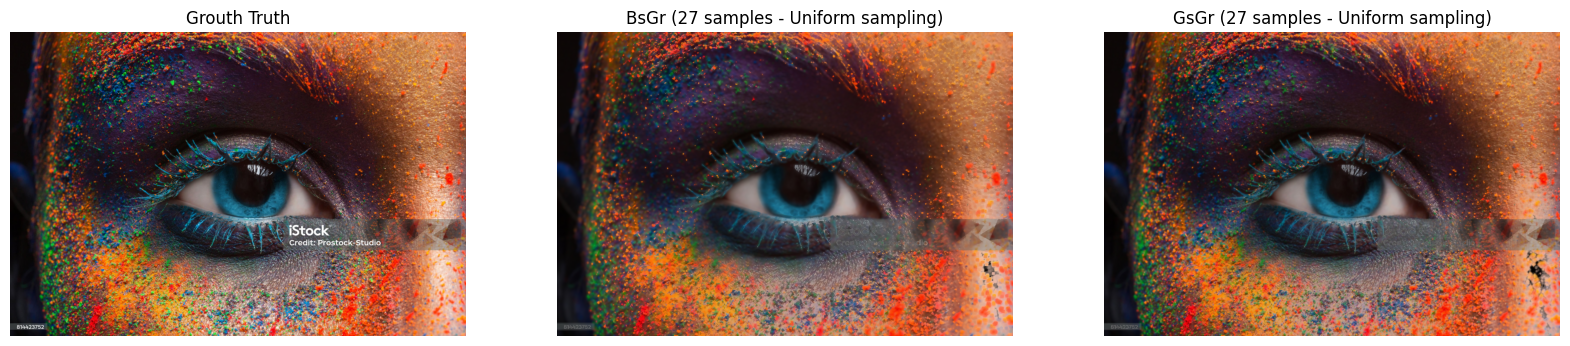

In [70]:
# ---------------- Test Pipeline ----------------
# 1. Load test image
img_bgr = cv2.imread(r'D:\Constant-time-Bilateral-Filtering\colors.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

# 2. Linearize and pipeline
img_lin = inv_gamma(img_rgb)
#samples = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)
samples = uniform_sampling(img_lin, num_samples=27)

Jks_bs, Wks_bs = box_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_bs = interpolate(img_lin, samples, Jks_bs, Wks_bs)
out_srgb_bs = gamma_corr(out_lin_bs)

Jks_gs, Wks_gs = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_gs = interpolate(img_lin, samples, Jks_gs, Wks_gs)
out_srgb_gs = gamma_corr(out_lin_gs)

# 3. Display results
fig, axs = plt.subplots(1,3,figsize=(20,12))
axs[0].imshow(img_rgb); axs[0].set_title('Grouth Truth'); axs[0].axis('off')
axs[1].imshow(np.clip(out_srgb_bs,0,1)); axs[1].set_title('BsGr (27 samples - Uniform sampling)'); axs[1].axis('off')
axs[2].imshow(np.clip(out_srgb_gs,0,1)); axs[2].set_title('GsGr (27 samples - Uniform sampling)'); axs[2].axis('off')
plt.show()

[Sampler] Poisson disk sampling: 5.033s → 27 samples


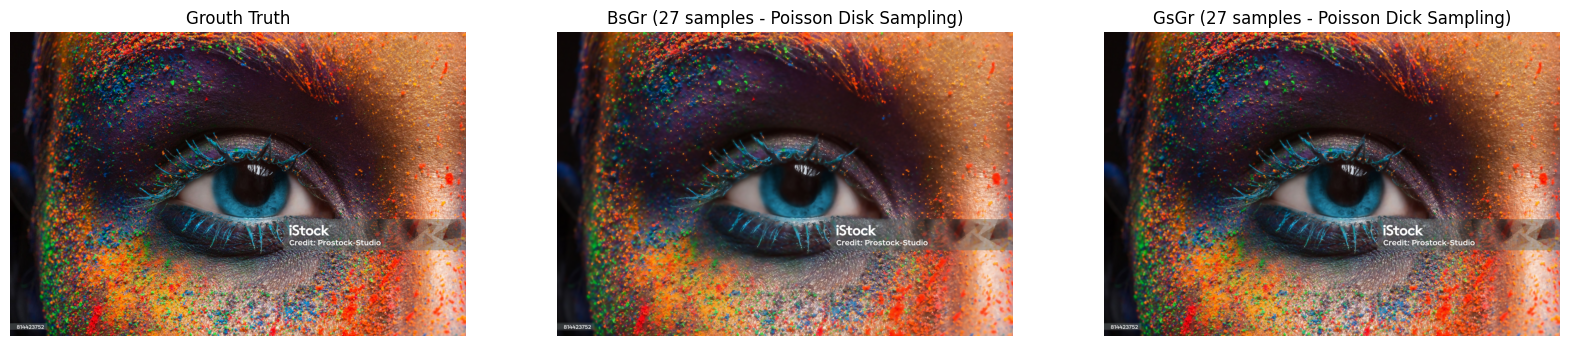

In [71]:
# ---------------- Test Pipeline ----------------
# 1. Load test image
img_bgr = cv2.imread(r'D:\Constant-time-Bilateral-Filtering\colors.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

# 2. Linearize and pipeline
img_lin = inv_gamma(img_rgb)
samples = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)
#samples = uniform_sampling(img_lin, num_samples=27)

Jks_bs, Wks_bs = box_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_bs = interpolate(img_lin, samples, Jks_bs, Wks_bs)
out_srgb_bs = gamma_corr(out_lin_bs)

Jks_gs, Wks_gs = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_gs = interpolate(img_lin, samples, Jks_gs, Wks_gs)
out_srgb_gs = gamma_corr(out_lin_gs)

# 3. Display results
fig, axs = plt.subplots(1,3,figsize=(20,12))
axs[0].imshow(img_rgb); axs[0].set_title('Grouth Truth'); axs[0].axis('off')
axs[1].imshow(np.clip(out_srgb_bs,0,1)); axs[1].set_title('BsGr (27 samples - Poisson Disk Sampling)'); axs[1].axis('off')
axs[2].imshow(np.clip(out_srgb_gs,0,1)); axs[2].set_title('GsGr (27 samples - Poisson Dick Sampling)'); axs[2].axis('off')
plt.show()

[Sampler] Poisson disk sampling: 0.366s → 27 samples


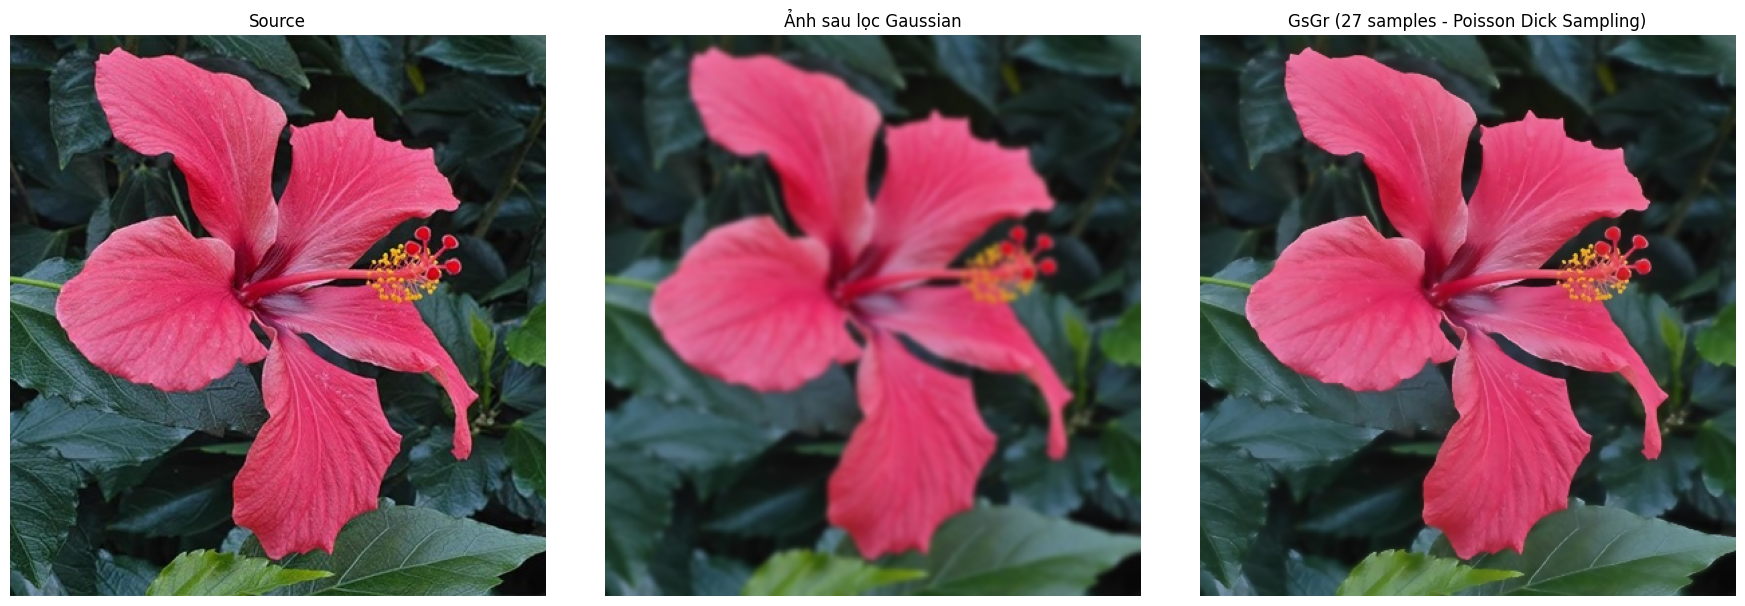

In [72]:
img = cv2.imread(r'D:\Constant-time-Bilateral-Filtering\test\flower.jpg')
blurred = cv2.GaussianBlur(img, (11, 11), 2.0)

img_rgb      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filtered_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
img_rgb_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

img_lin = inv_gamma(img_rgb_)
samples = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)
Jks_gs, Wks_gs = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_gs = interpolate(img_lin, samples, Jks_gs, Wks_gs)
out_srgb_gs = gamma_corr(out_lin_gs)

fig, axs = plt.subplots(1, 3, figsize = (18, 6))
axs[0].imshow(img_rgb)
axs[0].set_title('Source')
axs[0].axis('off')

axs[1].imshow(filtered_rgb)
axs[1].set_title('Ảnh sau lọc Gaussian')
axs[1].axis('off')

axs[2].imshow(np.clip(out_srgb_gs,0,1))
axs[2].set_title('GsGr (27 samples - Poisson Dick Sampling)')
axs[2].axis('off')

plt.tight_layout()
plt.show()

[Sampler] Poisson disk sampling: 0.283s → 27 samples
[Sampler] Poisson disk sampling: 0.425s → 64 samples
[Sampler] Poisson disk sampling: 0.293s → 27 samples
[Sampler] Poisson disk sampling: 0.433s → 64 samples
[Sampler] Poisson disk sampling: 0.411s → 27 samples
[Sampler] Poisson disk sampling: 0.493s → 64 samples
[Sampler] Poisson disk sampling: 0.430s → 27 samples
[Sampler] Poisson disk sampling: 0.411s → 64 samples
[Sampler] Poisson disk sampling: 0.342s → 27 samples
[Sampler] Poisson disk sampling: 0.560s → 64 samples
[Sampler] Poisson disk sampling: 0.356s → 27 samples
[Sampler] Poisson disk sampling: 0.500s → 64 samples
[Sampler] Poisson disk sampling: 0.355s → 27 samples
[Sampler] Poisson disk sampling: 0.510s → 64 samples
[Sampler] Poisson disk sampling: 0.408s → 27 samples
[Sampler] Poisson disk sampling: 0.561s → 64 samples
[Sampler] Poisson disk sampling: 0.380s → 27 samples
[Sampler] Poisson disk sampling: 0.433s → 64 samples
[Sampler] Poisson disk sampling: 0.287s → 27 s

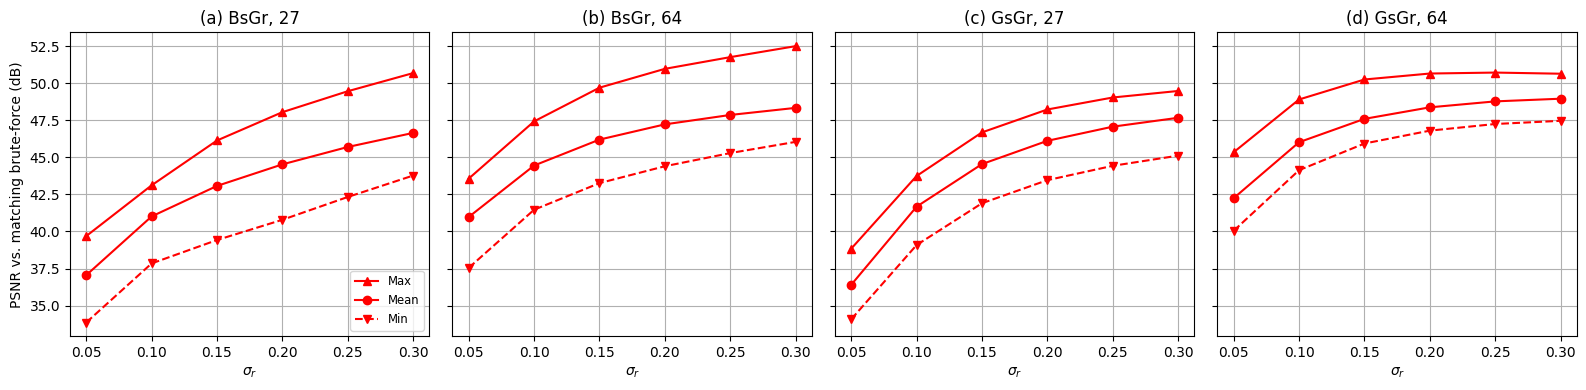

In [73]:
def compute_psnr(img_ref: np.ndarray, img_test: np.ndarray, max_val: float = 1.0):
    mse = np.mean((img_ref - img_test) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((max_val ** 2) / mse)

import math, os, glob, cv2, numpy as np, matplotlib.pyplot as plt
from numba import njit, prange

# ==============================================================
# 1)   BRUTE‑FORCE
# ==============================================================

@njit(parallel=True, fastmath=True)
def bilateral_bruteforce_box(img, radius=15, sigma_r=0.1, eps=1e-8):
    H, W, C = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for y in prange(H):
        for x in range(W):
            wp  = 0.0
            acc = np.zeros(C, np.float32)
            c0  = img[y, x]
            for dy in range(-radius, radius+1):
                yy = min(max(y+dy, 0), H-1)
                for dx in range(-radius, radius+1):
                    xx = min(max(x+dx, 0), W-1)
                    wr = math.exp(-np.sum((img[yy,xx]-c0)**2)/(2*sigma_r*sigma_r))
                    wp  += wr
                    acc += wr * img[yy, xx]
            out[y, x] = acc / (wp + eps)
    return out

@njit(parallel=True, fastmath=True)
def bilateral_bruteforce_gauss(img, radius=15, sigma_r=0.1, eps=1e-8):
    H, W, C = img.shape
    sigma_s2 = (radius/3.0)**2
    gsp = np.empty((2*radius+1, 2*radius+1), np.float32)
    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            gsp[dy+radius, dx+radius] = math.exp(-(dx*dx+dy*dy)/(2*sigma_s2))

    out = np.zeros_like(img, dtype=np.float32)
    for y in prange(H):
        for x in range(W):
            wp  = 0.0
            acc = np.zeros(C, np.float32)
            c0  = img[y, x]
            for dy in range(-radius, radius+1):
                yy = min(max(y+dy, 0), H-1)
                for dx in range(-radius, radius+1):
                    xx = min(max(x+dx, 0), W-1)
                    w = gsp[dy+radius, dx+radius] * \
                        math.exp(-np.sum((img[yy,xx]-c0)**2)/(2*sigma_r*sigma_r))
                    wp  += w
                    acc += w * img[yy, xx]
            out[y, x] = acc / (wp + eps)
    return out

# ==============================================================
# 2)   PIPELINE
# ==============================================================

def apply_proposed_filter(img_lin: np.ndarray,
                          method: str,
                          samples: np.ndarray,
                          sigma_r: float,
                          spatial_radius: int = 15) -> np.ndarray:
    if method == 'BsGr':
        Jks, Wks = box_filter(img_lin, samples,
                              sigma_r=sigma_r, spatial_radius=spatial_radius)
    elif method == 'GsGr':
        Jks, Wks = gaussian_iir_filter(img_lin, samples,
                                       sigma_r=sigma_r, spatial_radius=spatial_radius)
    else:
        raise ValueError(method)
    return interpolate(img_lin, samples, Jks, Wks)

# ==============================================================
# 3)   THỬ NGHIỆM
# ==============================================================

sigma_list = np.linspace(0.05, 0.30, 6)
configs = [('BsGr', 27), ('BsGr', 64), ('GsGr', 27), ('GsGr', 64)]
results = {cfg: [] for cfg in configs}

img_dir = r'D:\Image Processing\test'
paths = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
assert paths, 'No test images found!'

for path in paths:
    img_rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    img_lin = inv_gamma(img_rgb)

    for method, n in configs:
        samples = poisson_disk_sampling(img_lin, num_samples=n, initial_rs=0.1)
        psnrs = []
        for sigma in sigma_list:
            # ----- ground‑truth khớp kernel -----
            if method == 'BsGr':
                ref_lin = bilateral_bruteforce_box(img_lin, 15, sigma)
            else:  # GsGr
                ref_lin = bilateral_bruteforce_gauss(img_lin, 15, sigma)

            ref_srgb = gamma_corr(ref_lin)
            out_lin  = apply_proposed_filter(img_lin, method, samples,
                                             sigma, spatial_radius=15)
            out_srgb = gamma_corr(out_lin)

            psnrs.append(compute_psnr(ref_srgb, out_srgb))
        results[(method, n)].append(psnrs)

# ==============================================================
# 4)   VẼ ĐỒ THỊ
# ==============================================================

agg = {cfg: {'max': np.max(lst,0), 'mean': np.mean(lst,0), 'min': np.min(lst,0)}
       for cfg,lst in results.items()}

fig, axes = plt.subplots(1,4,figsize=(16,4),sharey=True)
titles = ['(a) BsGr, 27', '(b) BsGr, 64', '(c) GsGr, 27', '(d) GsGr, 64']
for ax, cfg, ttl in zip(axes, configs, titles):
    d = agg[cfg]
    ax.plot(sigma_list, d['max'],  'r^-', label='Max')
    ax.plot(sigma_list, d['mean'], 'ro-', label='Mean')
    ax.plot(sigma_list, d['min'],  'rv--', label='Min')
    ax.set_title(ttl); ax.set_xlabel(r'$\sigma_r$'); ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))

axes[0].set_ylabel('PSNR vs. matching brute-force (dB)')
axes[0].legend(loc='lower right', fontsize='small')
plt.tight_layout(); plt.show()

[Sampler] Poisson disk sampling: 0.481s → 27 samples


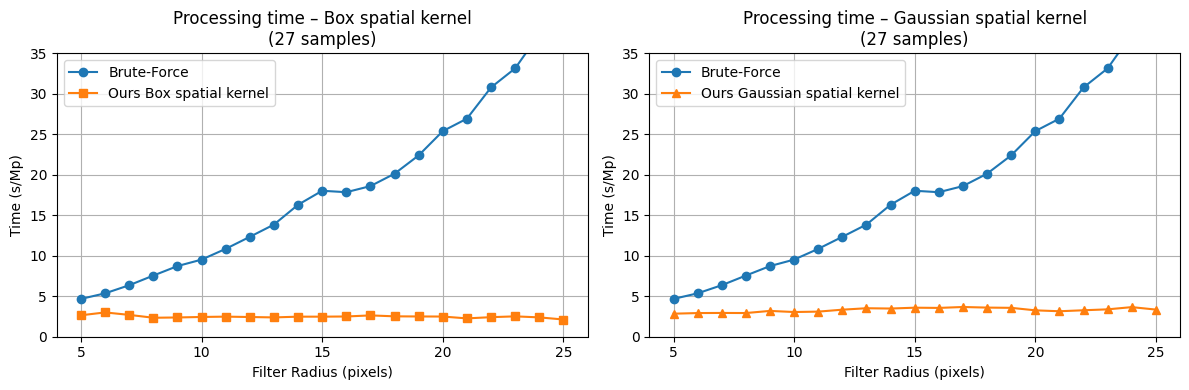

In [74]:
img_bgr = cv2.imread(r'D:\Image Processing\test\test6.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
img_lin = inv_gamma(img_rgb)

sampler = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)
samples = sampler

H, W = img_lin.shape[:2]
scale = (H * W) / 1e6

radii = list(range(5, 26, 1))
times_box = []
times_brute_force = []
times_gauss = []


for r in radii:
    t0 = time.time()
    Jks, Wks = box_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_box.append(t / scale)

_ = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius=5)
for r in radii:
    t0 = time.time()
    Jks, Wks = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_gauss.append(t / scale)

_ = brute_force_filter(img_lin, samples, sigma_r=0.1, spatial_radius=5)
for r in radii:
    t0 = time.time()
    Jks, Wks = brute_force_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_brute_force.append(t / scale)

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (a) Box spatial kernel comparison ---
axes[0].plot(radii, times_brute_force, marker='o', label='Brute-Force')
axes[0].plot(radii, times_box,         marker='s', label='Ours Box spatial kernel')
axes[0].set_title('Processing time – Box spatial kernel\n(27 samples)')
axes[0].set_xlabel('Filter Radius (pixels)')
axes[0].set_ylabel('Time (s/Mp)')
axes[0].grid(True)
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].set_ylim(0, 35)
axes[0].legend()

# --- (b) Gaussian spatial kernel comparison ---
axes[1].plot(radii, times_brute_force, marker='o', label='Brute-Force')
axes[1].plot(radii, times_gauss,       marker='^', label='Ours Gaussian spatial kernel')
axes[1].set_title('Processing time – Gaussian spatial kernel\n(27 samples)')
axes[1].set_xlabel('Filter Radius (pixels)')
axes[1].set_ylabel('Time (s/Mp)')
axes[1].grid(True)
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].set_ylim(0, 35)
axes[1].legend()

plt.tight_layout()
plt.show()

In [75]:
import os
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
from scipy.ndimage import gaussian_filter, map_coordinates

from _model import Net, ModelEMA

# ---------------------- Loss Functions ---------------------- #
def mae_loss(pred, tgt):
    return F.l1_loss(pred, tgt)

def depth_weighted_mae(pred, tgt):
    # Grab height (H) from the last-but-one dimension
    H = pred.shape[-2]
    # Create a (1×1×H×1) or (1×H×1) weight tensor that will broadcast properly
    weights = torch.linspace(1.0, 2.0, H, device=pred.device).view(
        *([1] * (pred.ndim - 2)),  # produces either (1, H, 1) or (1, 1, H, 1)
        H,
        1
    )
    return F.l1_loss(pred * weights, tgt * weights)


def spectral_loss(pred, tgt):
    P = torch.fft.rfftn(pred, dim=(-2, -1))
    T = torch.fft.rfftn(tgt, dim=(-2, -1))
    return F.l1_loss(torch.abs(P), torch.abs(T))

def charbonnier_edge_loss(pred, tgt, eps=1e-3):
    """Charbonnier edge-aware loss combining horizontal and vertical gradients."""
    # horizontal gradients (along width)
    gpred_x = pred[..., :, 1:] - pred[..., :, :-1]
    gtgt_x = tgt[..., :, 1:] - tgt[..., :, :-1]
    # vertical gradients (along height)
    gpred_y = pred[..., 1:, :] - pred[..., :-1, :]
    gtgt_y = tgt[..., 1:, :] - tgt[..., :-1, :]
    # compute Charbonnier loss components separately
    loss_x = torch.sqrt((gpred_x - gtgt_x)**2 + eps**2).mean()
    loss_y = torch.sqrt((gpred_y - gtgt_y)**2 + eps**2).mean()
    return loss_x + loss_y

def huber_loss(pred, tgt, delta=1.0):
    return F.huber_loss(pred, tgt, delta=delta)


def compute_total_loss(pred, tgt, use_huber=False):
    L_mae = mae_loss(pred, tgt)
    L_depth = depth_weighted_mae(pred, tgt)
    L_spec = spectral_loss(pred, tgt)
    L_edge = charbonnier_edge_loss(pred, tgt)
    L_hub = huber_loss(pred, tgt) if use_huber else 0.0
    total = 1.0 * L_mae + 0.5 * L_depth + 0.10 * L_spec + 0.01 * L_edge + 0.00 * L_hub
    return total, {"mae": L_mae.item(), "depth": L_depth.item(), "spec": L_spec.item(), "edge": L_edge.item()}

# ---------------------- Configuration ---------------------- #
@dataclass
class Config:
    backbone: str = "convnext_small.fb_in22k_ft_in1k"
    pretrained: bool = False
    ckpt_in: Path = Path("/kaggle/input/testft/FT/bartley_unet2d_convnext_seed1_epochbest_FT.pth")
    ckpt_out: Path = Path("curvefault_finetuned_best.pt")

    folds_csv: Path = Path("/kaggle/input/openfwi-preprocessed-72x72/folds.csv")
    base_dirs: tuple = (
        Path("/kaggle/input/open-wfi-1/openfwi_float16_1"),
        Path("/kaggle/input/open-wfi-2/openfwi_float16_2"),
    )
    focus_dataset: str = "CurveFault_B"
    samples_per_record: int = 500

    epochs: int = 30
    batch_size: int = 16
    val_batch_size: int = 16
    lr_backbone: float = 1e-5
    lr_head: float = 5e-5
    weight_decay: float = 1e-4

    T0: int = 10
    T_mult: int = 2
    eta_min: float = 1e-6

    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_bf16: bool = torch.cuda.is_bf16_supported()
    num_workers: int = 2
    log_interval: int = 50

# ---------------------- Dataset ---------------------- #
class CurveFaultDataset(Dataset):
    def __init__(self, cfg: Config, mode: str = "train"):
        assert mode in ("train", "valid"), "mode must be 'train' or 'valid'"
        self.cfg = cfg
        self.mode = mode
        self.augment = (mode == "train")
        self._load_index()

    def _resolve(self, rel_path: str) -> str:
        for d in self.cfg.base_dirs:
            p = d / rel_path
            if p.exists():
                return str(p)
        for d in self.cfg.base_dirs:
            for f in d.rglob(Path(rel_path).name):
                return str(f)
        raise FileNotFoundError(rel_path)

    def _load_index(self):
        df = pd.read_csv(self.cfg.folds_csv)
        df = df[df['dataset'] == self.cfg.focus_dataset]
        df = df[df['fold'] != 0] if self.mode == 'train' else df[df['fold'] == 0]

        self.data, self.target, self.weights = [], [], []
        for _, row in df.iterrows():
            data_fp = self._resolve(row['data_fpath'])
            target_fp = data_fp.replace('seis', 'vel').replace('data', 'model')
            self.data.append(np.load(data_fp, mmap_mode='r'))
            self.target.append(np.load(target_fp, mmap_mode='r'))
            self.weights.extend([3.0] * self.cfg.samples_per_record)

    def __len__(self):
        return len(self.data) * self.cfg.samples_per_record

    def __getitem__(self, idx):
        rec_idx, samp_idx = divmod(idx, self.cfg.samples_per_record)
        x = self.data[rec_idx][samp_idx].astype(np.float32).copy()
        y = self.target[rec_idx][samp_idx].astype(np.float32).copy()

        if self.augment:
            if np.random.rand() < 0.5:
                x = x[:, ::-1, ::-1].copy()
                y = y[:, ::-1, ::-1].copy() if y.ndim == 3 else y[::-1, ::-1].copy()
            if np.random.rand() < 0.3:
                c, h, w = x.shape
                dx = gaussian_filter((np.random.rand(h, w)*2-1), sigma=3)*20
                dy = gaussian_filter((np.random.rand(h, w)*2-1), sigma=3)*20
                xx, yy = np.meshgrid(np.arange(w), np.arange(h))
                idxs = (yy+dy).reshape(-1,1), (xx+dx).reshape(-1,1)
                out = np.zeros_like(x)
                for ch in range(c):
                    out[ch] = map_coordinates(x[ch], idxs, order=1, mode='reflect').reshape(h, w)
                x = out
            if np.random.rand() < 0.4:
                x = (x * np.random.uniform(0.95, 1.05)).astype(np.float32)

        x = np.ascontiguousarray(x)
        y = np.ascontiguousarray(y)
        return torch.from_numpy(x), torch.from_numpy(y)

# ---------------------- Training ---------------------- #
def fine_tune(cfg: Config):
    model = Net(cfg.backbone, pretrained=cfg.pretrained).to(cfg.device)
    state = torch.load(cfg.ckpt_in, map_location='cpu')
    model.load_state_dict(state, strict=False)

    for name, p in model.backbone.named_parameters():
        if 'stages.0' in name or 'stages.1' in name:
            p.requires_grad = False

    ema = ModelEMA(model, decay=0.995, device=cfg.device)

    train_ds = CurveFaultDataset(cfg, mode='train')
    val_ds = CurveFaultDataset(cfg, mode='valid')

    sampler = WeightedRandomSampler(train_ds.weights, num_samples=min(len(train_ds.weights), 8000), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler, num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.val_batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

    params = [
        {'params': filter(lambda p: p.requires_grad, model.backbone.parameters()), 'lr': cfg.lr_backbone},
        {'params': model.decoder.parameters(), 'lr': cfg.lr_head},
        {'params': model.seg_head.parameters(), 'lr': cfg.lr_head},
    ]
    opt = torch.optim.AdamW(params, weight_decay=cfg.weight_decay)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, cfg.T0, cfg.T_mult, cfg.eta_min)

    scaler = GradScaler(enabled=cfg.use_bf16)
    best_loss = float('inf')

    for epoch in range(cfg.epochs):
        model.train()
        train_metrics = {'mae': [], 'depth': [], 'spec': [], 'edge': []}
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(cfg.device), y.to(cfg.device)
            with autocast(device_type=cfg.device.type, dtype=torch.bfloat16 if cfg.use_bf16 else torch.float16):
                pred = model(x)
                loss, md = compute_total_loss(pred, y)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
            ema.update(model)
            for k, v in md.items(): train_metrics[k].append(v)
        sched.step()
        print({k: np.mean(v) for k, v in train_metrics.items()})

        model.eval()
        val_losses, val_metrics = [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc="Validation"):
                x, y = x.to(cfg.device), y.to(cfg.device)
                with autocast(device_type=cfg.device.type, dtype=torch.bfloat16 if cfg.use_bf16 else torch.float16):
                    pred = ema.module(x)
                    loss, md = compute_total_loss(pred, y)
                val_losses.append(loss.item())
                val_metrics.append(md)
        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}: Val MAE = {avg_val:.4f}")
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(ema.module.state_dict(), cfg.ckpt_out)
            print(f"  Saved new best model with MAE {best_loss:.4f}")

if __name__ == '__main__':
    fine_tune(Config())


ModuleNotFoundError: No module named '_model'